In [1]:
"""Script for optimization of a single topology"""
import multiprocess
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.moo.kgb import KGB
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import (
    TwoLinkGenerator,
    visualize_constrains,
)

from auto_robot_design.optimization.saver import (
    ProblemSaver,
)
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point,
)
from auto_robot_design.optimization.problems import (
    CalculateCriteriaProblemByWeigths,
    CalculateCriteriaMeanMultiTraj,
    CalculateCriteriaMeanTraj,
    get_optimizing_joints,
)
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import (
    ActuatedMass,
    EffectiveInertiaCompute,
    ImfCompute,
    ManipCompute,
    MovmentSurface,
    NeutralPoseMass,
    TranslationErrorMSE,
    ManipJacobian,
)
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import (
    convert_x_y_to_6d_traj_xz,
    get_simple_spline,
    get_vertical_trajectory,
    create_simple_step_trajectory,
)
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import (
    HeavyLiftingReward,
    AccelerationCapability,
)
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import (
    EndPointZRRReward,
    VelocityReward,
    ForceEllipsoidReward,
)
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import (
    TMotor_AK10_9,
    TMotor_AK60_6,
    TMotor_AK70_10,
    TMotor_AK80_64,
    TMotor_AK80_9,
)
from auto_robot_design.description.builder import (
    ParametrizedBuilder,
    DetailedURDFCreatorFixedEE,
    jps_graph2pinocchio_robot,
)

### Parametrization

#### 1) mechanism configuration

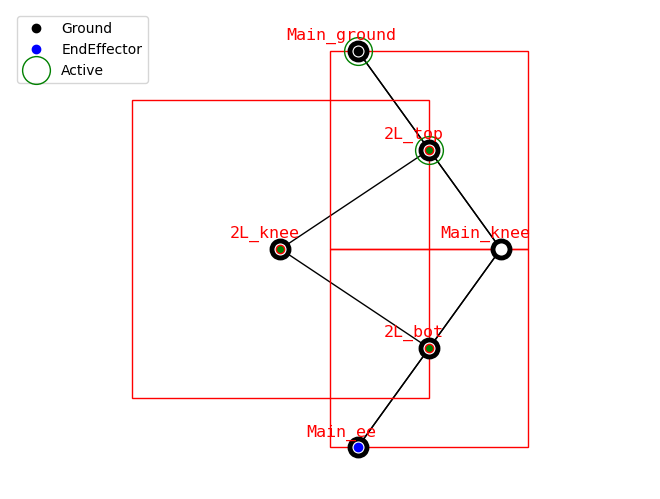

In [5]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(knee_pos = -0.4, shift=0.3)
graph, constrain_dict = all_graphs[1]

actuator = TMotor_AK10_9()
# actuator = TMotor_AK60_6()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

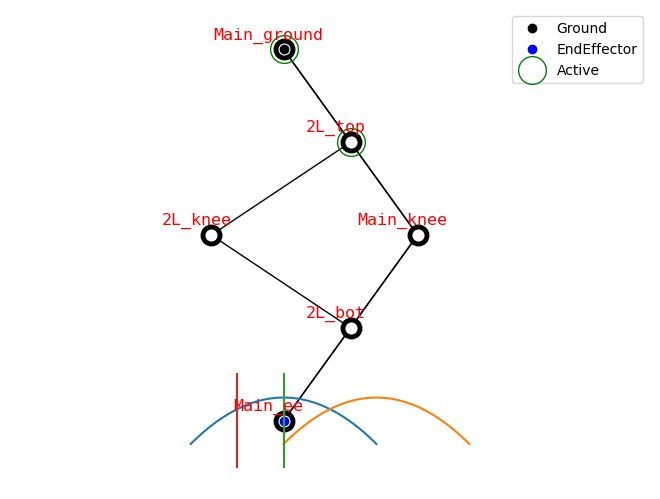

In [6]:
# trajectories
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.2, -0.85], step_height= 0.1, step_width=0.4,n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.4, -0.85], step_height= 0.1, step_width=0.4,n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.0, -0.85], step_height= 0.1, step_width=0.4,n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, 0,50))
left_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, -0.1,50))
right_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, 0.1,50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1e6), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1)]

step_trajectories = [ground_symmetric_step,left_shift_step,right_shift_step]
step_trajectories = [ground_symmetric_step, right_shift_step]

rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1e6),
           (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1)]

vertical_trajectories = [central_vertical, left_vertical, right_vertical]
vertical_trajectories = [central_vertical, left_vertical]

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]


draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

#### Calculate rewards for initial graph.

In [7]:
# create builder
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    mean_reward = np.zeros(len(trajectories))
    mean_partial = np.zeros((len(trajectories),len(rewards)))
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
            print(reward.__class__.__name__, current_partial[-1])
        mean_reward[trajectory_id] = current_total
        mean_partial[trajectory_id] = current_partial
    total_reward = np.mean(mean_reward)
    partial_rewards.append([total_reward]+list(np.mean(mean_partial, axis=0)))
    print(f"Rewards: {[reward.__class__.__name__ for reward, _ in rewards]}")
    print('Total reward:', total_reward.round(5), 'partial rewards at best trajectory:', partial_rewards[-1][1:])


PositioningReward 0
AccelerationCapability 19.000233864444414
PositioningReward 0
AccelerationCapability 16.954412595030075
Rewards: ['PositioningReward', 'AccelerationCapability']
Total reward: 17.97732 partial rewards at best trajectory: [0.0, 17.977323229737245]
PositioningReward 0
HeavyLiftingReward 3.577361132930133
PositioningReward 0
HeavyLiftingReward 2.7196783192163494
Rewards: ['PositioningReward', 'HeavyLiftingReward']
Total reward: 3.14852 partial rewards at best trajectory: [0.0, 3.148519726073241]


In [10]:
# from auto_robot_design.optimization.saver import (
#     load_checkpoint,
# )


# path = "results/test_2024-05-06_12-22-40"

# n_proccess = 8
# pool = multiprocess.Pool(n_proccess)
# runner = StarmapParallelization(pool.starmap)

# problem = CalculateCriteriaProblemByWeigths.load(
#     path,
#     builder,
#     crag,
#     **{"elementwise_runner":runner})
# checklpoint = load_checkpoint(path)

# optimizer = PymooOptimizer(problem, checklpoint)
# optimizer.load_history(path)

In [8]:
# activate multiprocessing
N_PROCESS = 8
pool = multiprocess.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [9]:
population_size = 32
n_generations = 20

# create the problem for the current optimization
problem = CalculateCriteriaMeanTraj(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            rewards_and_trajectories=rewards_and_trajectories,
                                            elementwise_runner=runner, 
                                            Actuator = actuator)
# problem = CalculateCriteriaMeanMultiTraj(graph,builder=builder,
#                                             jp2limits=optimizing_joints,
#                                             crag = crag,
#                                             rewards_and_trajectories=rewards_and_trajectories,
#                                             elementwise_runner=runner, Actuator = actuator)


In [10]:

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
# algorithm = KGB(save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


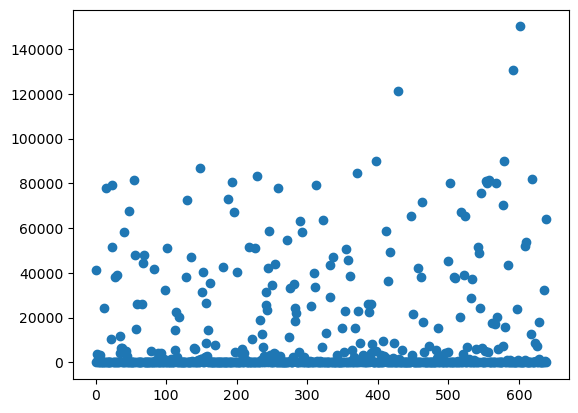

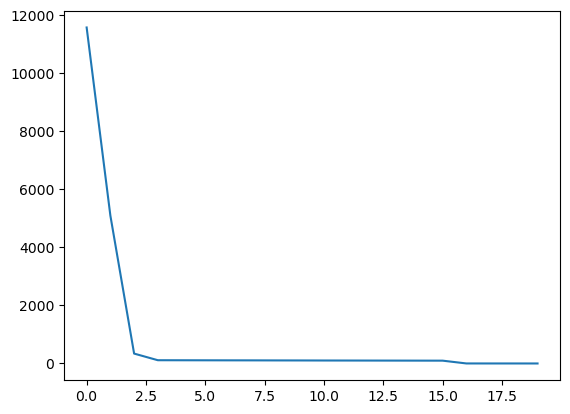

In [14]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [15]:
worst_id = np.argmax(optimizer.history["F"])
worst_reward = optimizer.history["F"][worst_id]
print('The maximum result in optimization task:', worst_reward.item())

The maximum result in optimization task: 150105.7484089749


The minimum result in optimization task: [-55.60426577]


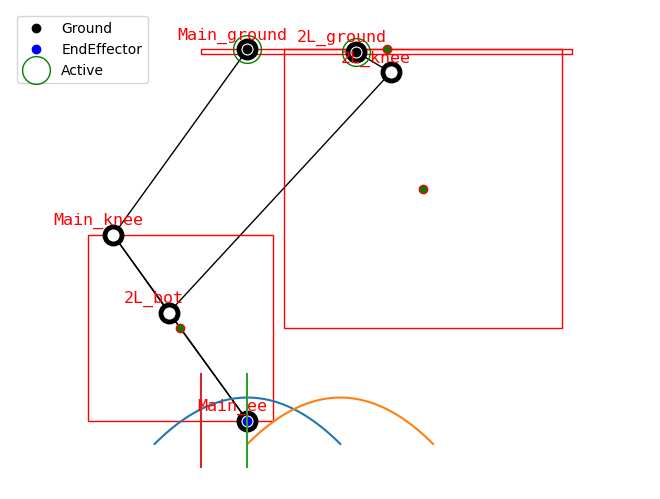

In [16]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("The minimum result in optimization task:", best_reward)

problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])
visualize_constrains(problem.graph, constrain_dict)


In [17]:
valid_arr_x_args = list(filter(lambda x: np.isclose(np.array(optimizer.history["Fs"])[x,0,1], 0), range(len(optimizer.history["Fs"])) ))

valid_arr_x = np.array(optimizer.history["X"])[valid_arr_x_args, :]
valid_arr_AC = np.array(optimizer.history["Fs"])[valid_arr_x_args, 0, 2]

valid_arr_X_AC = list(zip(valid_arr_x, valid_arr_AC))
valid_arr_X_AC_srtd = sorted(valid_arr_X_AC, key=lambda X_AC: X_AC[1])


In [18]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[50.18659921,  0.        , 50.18659921],
       [ 5.41766656,  0.        ,  5.41766656]])

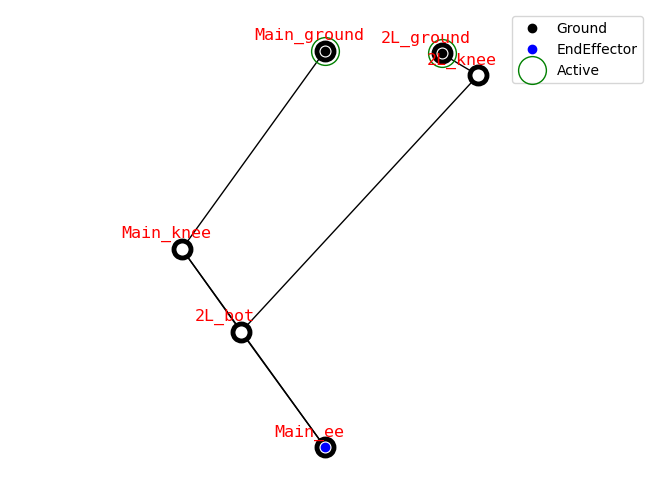

In [19]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

50.03979344380884
5.66715730652204


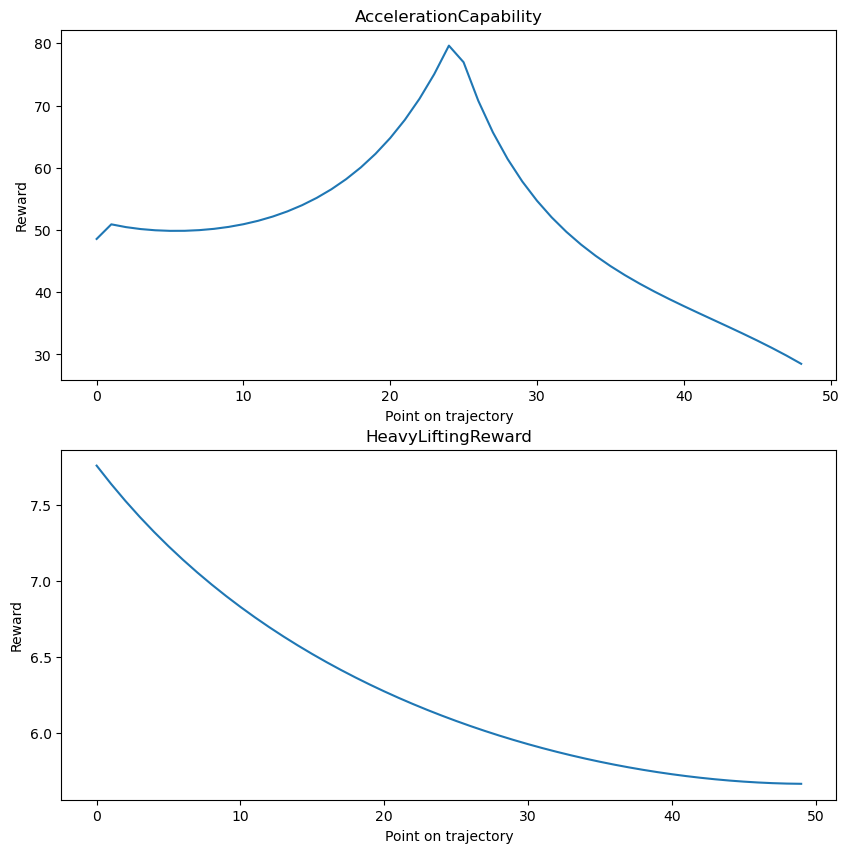

In [20]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
fig, axs, = plt.subplots(len(best_reward_decomposition),1, figsize=(10,10))
for i, ax, reward_decomposition in zip(range(len(best_reward_decomposition)), axs, best_reward_decomposition):
    trajectory = rewards_and_trajectories[i][1][0]


    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards_and_trajectories[i][0][1][0]

    print(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[0])
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
    ax.plot(reward_vector)
    ax.set_title(reward.__class__.__name__)
    ax.set_xlabel('Point on trajectory')
    ax.set_ylabel('Reward')
    reward_vector
plt.show()

In [21]:
len(valid_arr_X_AC)

391

In [22]:
coeffs = []

In [18]:
len(coeffs)

0

In [23]:

problem.mutate_JP_by_xopt(best_x)
# problem.mutate_JP_by_xopt(problem.initial_xopt)
compare_id = [15, 150, 200, 300, -1]
[valid_arr_X_AC_srtd[id][1] for id in compare_id]

[14.739846340303131,
 28.665250898999524,
 31.130354699500103,
 36.47253024375023,
 50.186599214938624]

In [20]:
[x_kp_kp[0] for x_kp_kp in coeffs]

[]

In [24]:

from auto_robot_design.simulation.trajectory_movments import TrajectoryMovements   
import auto_robot_design.simulation.evaluation as eval
import os
import dill
x_vars = [valid_arr_X_AC_srtd[id][0] for id in compare_id]



data = []
for x_var in x_vars:
    problem.mutate_JP_by_xopt(x_var)
    robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

    name_ee = "EE"

    # traj = vertical_trajectories[0][:,[0,2]]
    traj =  step_trajectories[0][:,[0,2]]
    test = TrajectoryMovements(traj, 0.8, 0.001, name_ee)

    time_arr, des_traj_6d, __ = test.prepare_trajectory(robo)
    # test.prepare_trajectory(robo)
    opt_ctrl_x_arr = [x_kp_kp[0] for x_kp_kp in coeffs]
    if opt_ctrl_x_arr and np.all(x_var == opt_ctrl_x_arr, axis=1).any():
        id_ctrl = np.argwhere(np.all(x_var == opt_ctrl_x_arr, axis=1)).squeeze()
        Kp = coeffs[id_ctrl][1]
        Kd = coeffs[id_ctrl][2]
    else:
        Kp, Kd = test.optimize_control(robo)
        coeffs.append((x_var, Kp, Kd))

    test.Kp = Kp
    test.Kd = Kd
    
    # # q, vq, acc, tau, pos_ee, power
    data.append(test.simulate(robo, False))


     1 |        5 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  1.118183E+02 |  1.870135E+01
     2 |       10 | -7.0E-01 |       3 |  0.0965 |  2.00000 |  2.01955 |  7.342106E+01 |  1.870135E+01
     3 |       15 | -3.7E-01 |       3 |  0.2047 |  1.99045 |  2.03233 |  5.122295E+01 |  1.870135E+01
     4 |       20 | -2.0E-01 |       3 |  0.2849 |  1.97965 |  2.04904 |  3.386073E+01 |  1.870135E+01
     5 |       25 | -2.0E-01 |       3 |  0.2823 |  1.96624 |  2.06099 |  2.407642E+01 |  1.675406E+01
     6 |       30 | -8.6E-02 |       3 |  0.3478 |  1.95401 |  2.07558 |  2.071496E+01 |  1.675406E+01
     7 |       35 | -9.4E-02 |       3 |  0.3432 |  1.94082 |  2.08591 |  2.015257E+01 |  1.462791E+01
     8 |       40 | -1.7E-01 |       3 |  0.2987 |  1.92954 |  2.09954 |  1.593913E+01 |  1.462791E+01
     9 |       45 | -1.4E-01 |       3 |  0.3185 |  1.91680 |  2.10457 |  1.400986E+01 |  1.088115E+01
    10 |       50 | -1.3E-01 |       3 |  0.3222 |  1.90777 |  2.11001 | 

/home/yefim-work/Documents/Be2rLab/CoDesign/auto-robotics-design/auto_robot_design/simulation/trajectory_movments.py:250: RuntimeWarning: overflow encountered in multiply
  power[i] = tau_a * vq_a
/home/yefim-work/miniconda3/envs/j_moves/lib/python3.9/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


     1 |        5 |        - |       - |  0.9000 |  2.00000 |  2.00000 |           INF |  4.0319942350
     2 |       10 | -7.5E-01 |       3 |  0.0874 |  2.00000 |  2.01593 |  1.269522E+01 |  4.0319942350
     3 |       15 | -2.4E-01 |       3 |  0.2643 |  1.99221 |  2.02998 |  7.2304379633 |  3.3423566882
     4 |       20 | -1.4E-01 |       3 |  0.3168 |  1.98165 |  2.04716 |  5.3126253272 |  3.3423566882
     5 |       25 | -3.4E-01 |       3 |  0.2180 |  1.96812 |  2.05892 |  3.5648281955 |  2.8868283669
     6 |       30 | -1.2E-01 |       3 |  0.3256 |  1.95569 |  2.06853 |  2.8209040898 |  2.6510090386
     7 |       35 | -7.2E-01 |       3 |  0.0922 |  1.94514 |  2.08284 |  2.4190765553 |  2.1568653730
     8 |       40 | -3.0E-01 |       3 |  0.2348 |  1.93293 |  2.09319 |  2.1840424813 |  1.7256471746
     9 |       45 | -8.3E-02 |       3 |  0.3493 |  1.92159 |  2.10005 |  1.8199802550 |  1.7050800689
    10 |       50 | -2.9E-02 |       3 |  0.3820 |  1.91335 |  2.11590 | 

In [26]:

pathfile_ctrl = os.path.join(saver.path, "ctrl_coeffs.pkl")

with open(pathfile_ctrl, "wb") as f:
    dill.dump(coeffs, f)


In [27]:
len(coeffs)

5

In [28]:
coeffs[np.argwhere(np.all(x_var == opt_ctrl_x_arr, axis=1)).squeeze()]

TypeError: only integer scalar arrays can be converted to a scalar index

In [33]:
np.array(data).shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (5, 6, 800) + inhomogeneous part.

In [30]:

print(f"PQ: {eval.compare_power_quality(time_arr, data, True)}")
print(f"Error {eval.compare_movments_in_xz_plane(time_arr, data, des_traj_6d[:,:3], True)}")
print(f"Max Torque {eval.compare_torque_evaluation(time_arr, data, True)}")

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
np.mean(np.abs(data[0][3]), axis=0), np.mean(np.abs(data[1][3]), axis=0)

(array([16.90697021, 11.64583766]), array([13.37287237,  8.29205248]))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


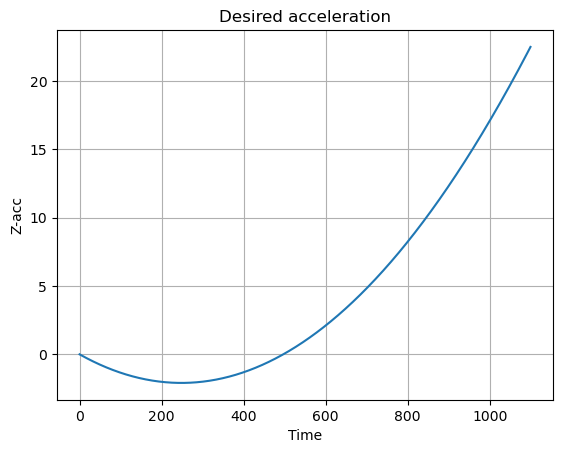

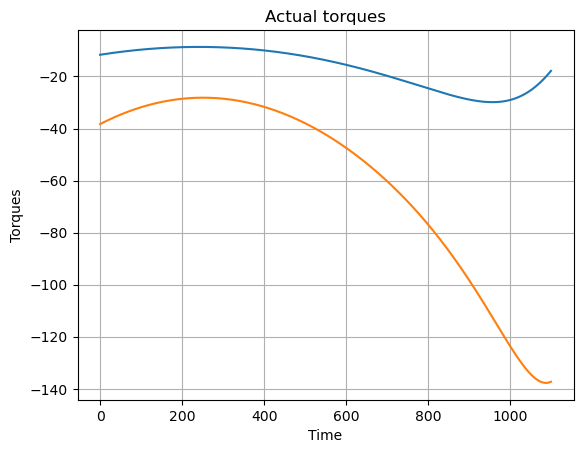

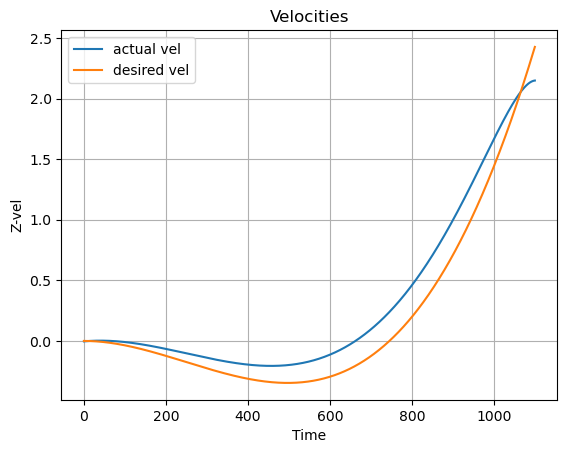

In [44]:
from auto_robot_design.description.builder import jps_graph2urdf_by_bulder
from auto_robot_design.pinokla.squat import SquatHopParameters, SimulateSquatHop

robo_urdf, joint_description, loop_description = jps_graph2urdf_by_bulder(
    graph, builder)

sqh_p = SquatHopParameters(hop_flight_hight=0.3,
                           squatting_up_hight=0,
                           squatting_down_hight=-0.1,
                           total_time=0.55)
hoppa = SimulateSquatHop(sqh_p)


q_act, vq_act, acc_act, tau = hoppa.simulate(
    robo_urdf, joint_description, loop_description, is_vis=True)

trj_f = hoppa.create_traj_equation()
t = np.linspace(0, sqh_p.total_time,  len(q_act))
list__234 = np.array(list(map(trj_f, t)))


plt.figure()
plt.plot(list__234[:, 2])
plt.title("Desired acceleration")
plt.xlabel("Time")
plt.ylabel("Z-acc")
plt.grid(True)

plt.figure()
plt.plot(tau[:, 0])
plt.plot(tau[:, 1])
plt.title("Actual torques")
plt.xlabel("Time")
plt.ylabel("Torques")
plt.grid(True)


plt.figure()

plt.plot(vq_act[:, 0])
plt.plot(list__234[:, 1])
plt.title("Velocities")
plt.xlabel("Time")
plt.ylabel("Z-vel")
plt.legend(["actual vel", "desired vel"])
plt.grid(True)

plt.show()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


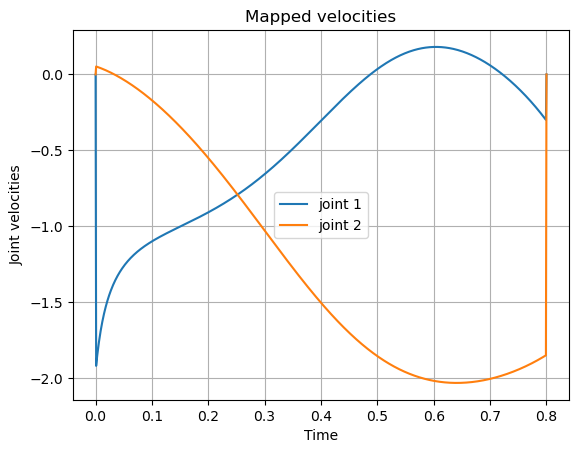

In [27]:
from auto_robot_design.pinokla.criterion_agregator import calculate_quasi_static_simdata
from pinocchio.visualize import MeshcatVisualizer
import meshcat

problem.mutate_JP_by_xopt(best_x)
trajectory = rewards_and_trajectories[0][1][1]

viz = MeshcatVisualizer(robo.model, robo.visual_model, robo.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
res_dict_free, res_dict_fixed = calculate_quasi_static_simdata(free_robot, fixed_robot, crag.end_effector_name, des_traj_6d, viz)

des_traj_6d_tangent = np.diff(des_traj_6d, axis=0)
for i in range(1, len(des_traj_6d_tangent)):
    des_traj_6d_tangent[i] = des_traj_6d_tangent[i] / np.linalg.norm(des_traj_6d_tangent[i])
arr_Jclosed = res_dict_fixed["J_closed"] 

des_traj_6d_tangent = np.vstack([des_traj_6d_tangent, np.zeros(6)])

q_mapped = np.zeros((len(des_traj_6d_tangent), 2))
for i in range(len(des_traj_6d_tangent)):
    q_mapped[i] = np.linalg.pinv(arr_Jclosed[i]) @ des_traj_6d_tangent[i]

q_mapped[:,0] = np.array([q_mapped[i,0] if np.abs(q_mapped[i,0]) <= 10 else 10 for i in range(len(q_mapped))])
q_mapped[:,1] = np.array([q_mapped[i,1] if np.abs(q_mapped[i,1]) <= 10 else 10 for i in range(len(q_mapped))])
plt.figure()
plt.plot(time_arr,q_mapped[:, 0])
plt.plot(time_arr,q_mapped[:, 1])
plt.title("Mapped velocities")
plt.xlabel("Time")
plt.ylabel("Joint velocities")
plt.legend(["joint 1", "joint 2"])
plt.grid(True)
plt.show()